In [1]:
import numpy as np
import util
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelsize"] = "16"

In [6]:
class MagneticMirror2D(object):

    #######################################################################
    # Begin physical parameters                                           #
    #######################################################################

    # domain size in meter
    Lx = 1e-2 # r direction
    Lz = 1e-1

    # spatial resolution in number of cells
    Nx = 160
    Nz = 1600

    # mirror ratio
    R = 10.0
    B_max = 0.3  # T

    # use a reduced ion mass for faster simulations
    m_e = util.constants.m_e
    m_ion = 400.0 * m_e
    # m_ion = util.constants.m_p

    # initial seed macroparticle density
    nppc_seed = 5  # 800

    # total simulation time in ion thermal crossing times
    crossing_times = 0.5

    def __init__(self):
        # plasma density m^{-3}
        self.n0 = 1e16

        # temperature
        self.Te = 300 # eV
        self.Ti = 60

        self.dx = self.Lx / self.Nx
        self.dz = self.Lz / self.Nz

        # calculate electron plasma frequency
        w_pe = util.plasma_freq(self.n0)
        # self.dt = 0.07 / w_pe
        # simulation timestep from electron CFL
        # self.dt = self.dz / (5.0 * util.thermal_velocity(self.Te, util.constants.m_e))
        self.dt = 0.5 / util.cyclotron_freq(self.m_e, self.B_max)

        # calculate the ion crossing time to get the total simulation time
        ion_crossing_time = self.Lz / \
            util.thermal_velocity(self.Ti, self.m_ion)
        self.total_steps = int(np.ceil(
            self.crossing_times * ion_crossing_time / self.dt
        ))
        self.diag_steps = int(self.total_steps / 20.0)

        # calculate the flux from the thermal plasma reservoir
        self.flux_e = (
            self.n0 * util.thermal_velocity(self.Te, util.constants.m_e) / np.sqrt(2.0 * np.pi)
        )
        # self.flux_i = self.flux_e * np.sqrt(util.constants.m_e / self.m_ion)
        self.flux_i = (
            self.n0 * util.thermal_velocity(self.Ti, self.m_ion)
        )

        # check spatial resolution
        self.debye_length = util.debye_length(self.Te, self.n0)

        print("Starting simulation with parameters:")
        print(f"    Lz = {self.Lz}m, Lx = {self.Lx}m")
        print(f"    Nz = {self.Nz}, Nx = {self.Nx}")
        print(f"    dz = {self.dz*1e6:.1f}um, dx = {self.dx*1e6:.1f}um")
        print(f"    Debye length = {self.debye_length*1e6:.1f} um")
        print(f"    Electron plasma frequency = {w_pe:.1f} Hz")
        print(f"    T_e = T_i = {self.Te:.3f} eV")
        print(f"    n0 = {self.n0:.1e} m^-3")
        print(f"    M/m = {self.m_ion/util.constants.m_e:.0f}")
        # print(f"    flux_e = {self.flux_e*util.constants.e:.1f} A/m2")
        print(f"    flux_i = {self.flux_i*util.constants.e:.1f} A/m2")
        print(f"    Ion crossing time: {ion_crossing_time}")
        print(f"    Ion crossing steps: {ion_crossing_time / self.dt:.0f}")
        print(f"    Total steps = {self.total_steps}")
mirror = MagneticMirror2D()


Starting simulation with parameters:
    Lz = 0.1m, Lx = 0.01m
    Nz = 1600, Nx = 160
    dz = 62.5um, dx = 62.5um
    Debye length = 1286.9 um
    Electron plasma frequency = 5641460231.2 Hz
    T_e = T_i = 300.000 eV
    n0 = 1.0e+16 m^-3
    M/m = 400
    flux_i = 368.0 A/m2
    Ion crossing time: 4.353572213893743e-07
    Ion crossing steps: 45943
    Total steps = 22972


In [7]:
num_cores = 80
time_per_step = 2 # second
total_time = np.round(time_per_step*mirror.total_steps / num_cores / 3600, 1) # in hours
print(f"using {num_cores} cores, total_time={total_time} hours")

using 80 cores, total_time=0.2 hours


We can have a much more accurate estimate by using the output log from previous runs

Processing diags202312061235/output.log ......done!
total time: 4.995234322541108 hours


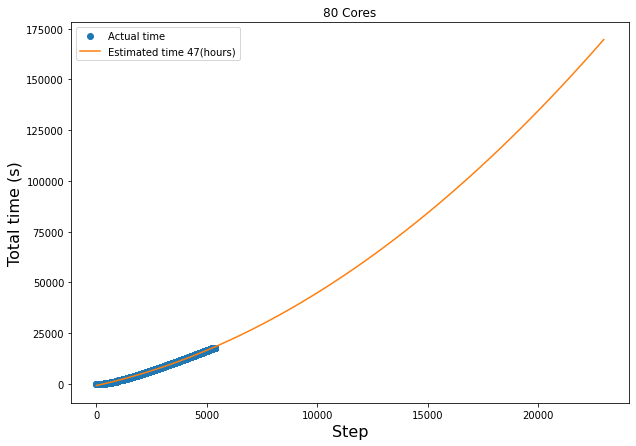

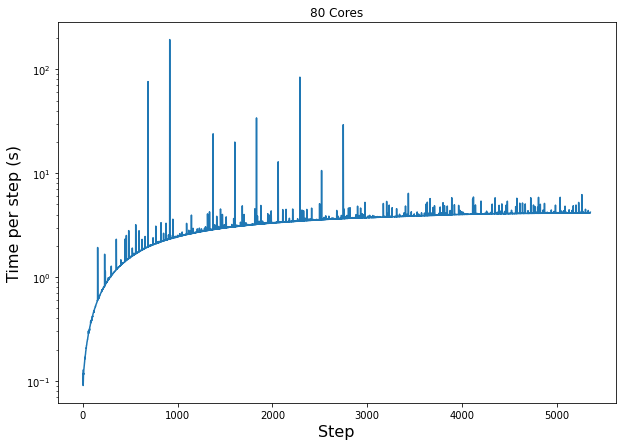

In [10]:

output_file = "diags202312061235/output.log"
specs, time_data = util.extract_data(output_file)
steps = time_data[:,0]
time_per_step = time_data[:,4]
total_times = time_data[:,4].cumsum()
plt.figure(figsize=(10,7))
plt.plot(steps, total_times, "o")
plt.xlabel("Step")
plt.ylabel("Total time (s)")
plt.title(f"{specs['cores']} Cores")

p = np.polyfit(steps, total_times, 2)
estimate_steps = np.linspace(1,mirror.total_steps)
estimate_times = np.polyval(p, estimate_steps)
plt.plot(estimate_steps, estimate_times)
plt.legend(["Actual time", f"Estimated time {int(estimate_times[-1]/3600)}(hours)"])

# print(f"Estimated to take {estimate_times[-1]/3600} hours using {specs['cores']} cores and {specs['omp_threads']} OMP threads")
plt.figure(figsize=(10,7))
plt.semilogy(steps, time_per_step)
plt.xlabel("Step")
plt.ylabel("Time per step (s)")
plt.title(f"{specs['cores']} Cores")

print(f"total time: {total_times[-1] / 3600} hours")

In [12]:
Lz, Nz = 0.10, 256
Bmax = 0.3
T_e = 300
dz = Lz/Nz
dt = dz / 5 / util.thermal_velocity(T_e, util.constants.m_e)
cyc_period = 1/util.cyclotron_freq(util.constants.m_e, Bmax)

print("is dt < cyc_period:", dt < cyc_period)

is dt < cyc_period: True
